# About this notebook

This notebook explores methods of integrating fire occurrence predictions with economic data in order to estimate fire risk.
The economic data available to us are the value of structures, vehicles, and structure contents for San Diego county in the years 2011 and 2019. Here we explore predictions for the 2007 fire season using economic data from 2011 as a proxy for economic data in 2007, since the actual data from 2007 is not available to us.

## Loading the fire predictions

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('darkgrid')

In [2]:
%%time
import pandas as pd
import pyarrow.parquet as pq
import s3fs
import boto3

YEAR = 2007
prediction_url = 'wildfire_capstone/logistic_regression_predictions/{}/predictions.parquet.gz/'.format(YEAR)
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')
s3_keys = [item.key
           for item in s3_resource.Bucket('dse-cohort5-group5').objects.filter(Prefix=prediction_url)
           if item.key.endswith('.parquet')]
display(s3_keys[:3])
s3 = s3fs.S3FileSystem()
s3_url = 'dse-cohort5-group5/{}'
dfs = [pq.ParquetDataset(s3_url.format(key), filesystem=s3).read_pandas().to_pandas() for key in s3_keys]

['wildfire_capstone/logistic_regression_predictions/2007/predictions.parquet.gz/part-00000-6e5f6da6-a646-4514-ab09-6ac08fd858be-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2007/predictions.parquet.gz/part-00001-6e5f6da6-a646-4514-ab09-6ac08fd858be-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2007/predictions.parquet.gz/part-00002-6e5f6da6-a646-4514-ab09-6ac08fd858be-c000.snappy.parquet']

Wall time: 1min 1s


In [3]:
num_rows = sum(len(df) for df in dfs)
num_rows

324850

In [4]:
dfs[0].head()

,date,latitude,longitude,fire_occurred,acres_burned,year,month,day,prediction
0,1192924800000000000,32.691667,-116.891667,1,90728.328125,2007,10,21,1.0
1,1193011200000000000,33.191667,-117.016667,1,164038.218000,2007,10,22,1.0
2,1193097600000000000,33.066667,-116.850000,1,108911.685000,2007,10,23,1.0
3,1193184000000000000,33.316667,-116.975000,1,179845.721000,2007,10,24,1.0
4,1193270400000000000,33.066667,-117.141667,1,164491.284000,2007,10,25,1.0


In [5]:
%%time
for df in dfs:
    df.date = pd.to_datetime(df.date)
    df.prediction = df.prediction.astype('int')
    df.set_index(['date', 'latitude', 'longitude'], inplace=True)
dfs[0].head()

Wall time: 1.38 s


,,,fire_occurred,acres_burned,year,month,day,prediction
date,latitude,longitude,,,,,,
2007-10-21,32.691667,-116.891667,1,90728.328125,2007,10,21,1
2007-10-22,33.191667,-117.016667,1,164038.218000,2007,10,22,1
2007-10-23,33.066667,-116.850000,1,108911.685000,2007,10,23,1
2007-10-24,33.316667,-116.975000,1,179845.721000,2007,10,24,1
2007-10-25,33.066667,-117.141667,1,164491.284000,2007,10,25,1


In [6]:
complete_df = pd.concat(dfs)
print(complete_df.shape)
complete_df.head()

(324850, 6)


,,,fire_occurred,acres_burned,year,month,day,prediction
date,latitude,longitude,,,,,,
2007-10-21,32.691667,-116.891667,1,90728.328125,2007,10,21,1
2007-10-22,33.191667,-117.016667,1,164038.218000,2007,10,22,1
2007-10-23,33.066667,-116.850000,1,108911.685000,2007,10,23,1
2007-10-24,33.316667,-116.975000,1,179845.721000,2007,10,24,1
2007-10-25,33.066667,-117.141667,1,164491.284000,2007,10,25,1


In [7]:
np.sum(complete_df.fire_occurred)

1077

In [8]:
np.sum(complete_df.prediction)

131731

In [9]:
yearly_totals_df = complete_df.groupby(by=['latitude', 'longitude']).agg(
    total_actual_fires=pd.NamedAgg(column='fire_occurred', aggfunc='sum'),
    total_predicted_fires=pd.NamedAgg(column='prediction', aggfunc='sum'),
)
yearly_totals_df.head()

total_actual_fires  total_predicted_fires
latitude  longitude                                             
32.483333 -117.141667                   0                    203
          -117.100000                   0                    292
          -117.058333                   0                    304
          -117.016667                   0                    295
          -116.975000                   0                    253

In [10]:
yearly_totals_df.total_actual_fires.value_counts()

0    696
8     62
6     30
1     21
7     20
3     19
2     13
4     12
5     11
9      6
Name: total_actual_fires, dtype: int64

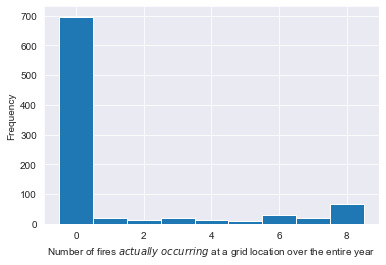

In [22]:
ax = yearly_totals_df.total_actual_fires.hist(bins=9, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{actually\ occurring}$ at a grid location over the entire year");

In [23]:
yearly_totals_df.total_predicted_fires.value_counts()

0      52
209    10
192    10
150    10
215     9
       ..
51      1
241     1
246     1
43      1
304     1
Name: total_predicted_fires, Length: 249, dtype: int64

In [24]:
np.max(yearly_totals_df.total_predicted_fires.value_counts().index)

304

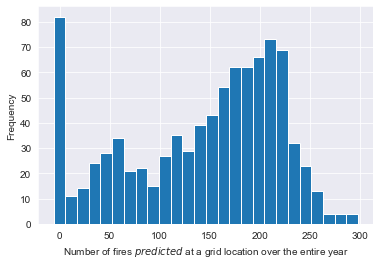

In [25]:
ax = yearly_totals_df.total_predicted_fires.hist(bins=268//10, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{predicted}$ at a grid location over the entire year");

In [26]:
yearly_totals_df['%_days_predicted_fires'] =yearly_totals_df.total_predicted_fires / 365

Pearson correlation coefficient: 0.2850784352417274


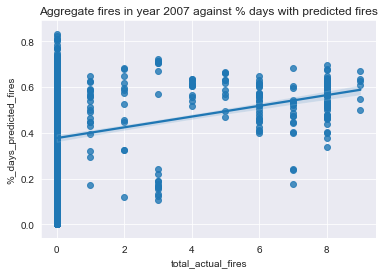

In [48]:
pearson = yearly_totals_df.loc[:, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
print("Pearson correlation coefficient:", pearson)
ax = sns.regplot(data=yearly_totals_df, x='total_actual_fires', y='%_days_predicted_fires')
ax.set_title("Aggregate fires in year {} against % days with predicted fires".format(YEAR));

## Some observations

There is a slight correlation between the number of predicted fires and the number of actual fires overall.
Can we get better results by restricting our attention to some particular grid locations? For example, do we get good predictions at the most valuable grid locations?

# Economic data

Let's explore the economic data a bit to determine the most valuable grid locations.

In [28]:
econ_df = pd.read_csv('grid_econ_1.csv', index_col=0)
print(econ_df.shape)
econ_df.head()

(507, 10)


,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN


In [29]:
econ_df['total_value'] = np.sum(econ_df[['Val_Struct', 'Val_Cont', 'Val_Other', 'Val_Vehic']], axis=1)
econ_df.head()

,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential,total_value
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0,2.430361e+08
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0,4.430585e+07
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0,3.829353e+08
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0,1.035808e+08
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN,4.599620e+06


(152, 11)
Pearson correlation coefficient: 0.3444619834426786


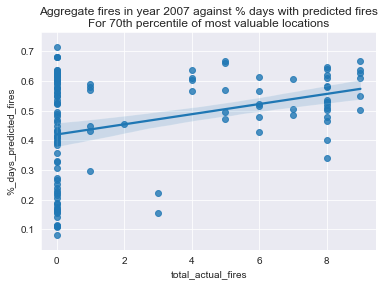

In [47]:
mask = (econ_df.total_value > econ_df.total_value.quantile(0.7))
most_valuable_locations = econ_df[mask]
print(most_valuable_locations.shape)
most_valuable_lons = most_valuable_locations.longitude
most_valuable_lats = most_valuable_locations.latitude
mask = (yearly_totals_df.reset_index().latitude.isin(most_valuable_lats) &
       yearly_totals_df.reset_index().longitude.isin(most_valuable_lons))
pearson = yearly_totals_df.reset_index().loc[mask, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
print("Pearson correlation coefficient:", pearson)
ax = sns.regplot(data=yearly_totals_df.reset_index()[mask], x='total_actual_fires', y='%_days_predicted_fires');
ax.set_title("Aggregate fires in year {} against % days with predicted fires\n"
             "For 70th percentile of most valuable locations".format(YEAR));

## Conclusions

With enough fire data points, we see that there is a modest correlation between predicted fires and the actual number of fires for the most valuable areas. This is a promising result although there is still a clear need for greater precision.